<a href="https://colab.research.google.com/github/thienluc2017/BERT_19021324/blob/main/PhoBERT_19021324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pytorch-lightning
!pip install transformers
!pip install sentencepiece
!pip install fairseq


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA

In [3]:
# replace this path to your dataset directory
DATA_ROOT_DIR="/content/drive/MyDrive/colab/shopee-sentiment"
!ls $DATA_ROOT_DIR

sample_submission.csv  train_preprocess.csv
test.csv	       train_preprocess_unsegment.csv
test_preprocess.csv    train_preprocess_unsegment.gsheet
train.csv	       train.xlsx


In [4]:
# include some dependence
import pandas as pd
import numpy as np
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl
import torch.nn as nn
import torch

train_ratio = 0.8
DATA_DIR = DATA_ROOT_DIR + '/train_preprocess_unsegment.csv'

In [5]:
# Use pandas to read csv, this will return a excel like table data
train = pd.read_csv(DATA_DIR, index_col=0)
train.sample()

,id,text,class,preprocess_text
8827,4e3b0c48,"Mình đến đây làm với 1 người bạn , mình thích ...",1,mình đến đây làm với 1 người bạn mình thích nh...


In [6]:
from typing import *

class SentimentData(Dataset):
    """
    Dataset class for sentiment analysis. 
    Every dataset using pytorch should be overwrite this class
    This require 2 function, __len__ and __getitem__
    """
    def __init__(self, data_dir):
        """
        Args:
            data_dir (string): Directory with the csv file
        """
        self.df = pd.read_csv(data_dir, index_col=0)

    def __len__(self):
        """
        length of the dataset, i.e. number of rows in the csv file
        Returns: int 
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        given a row index, returns the corresponding row of the csv file
        Returns: text (string), label (int) 
        """
        text = self.df["preprocess_text"][idx]
        label = self.df["class"][idx]

        return text, label


class SentimentDataModule(pl.LightningDataModule):
    """
    Module class for sentiment analysis. this class is used to load the data to the model. 
    It is a subclass of LightningDataModule. 
    """

    def __init__(self, data_dir: str = DATA_DIR, batch_size: int = 32):
        """
        Args:
            data_dir (string): Directory with the csv file
            batch_size (int): batch size for dataloader
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None):
        """
        Loads the data to the model. 
        the data is loaded in the setup function, so that it is loaded only once. 
        """
        data_full = SentimentData(self.data_dir)
        train_size = round(len(data_full) * train_ratio)
        val_size = len(data_full) - train_size
        print(len(data_full), train_size, val_size)
        self.data_train, self.data_val = random_split(data_full, [train_size, val_size])

    def train_dataloader(self):
        """
        Returns: dataloader for training
        """
        return DataLoader(self.data_train, batch_size=self.batch_size)

    def val_dataloader(self):
        """
        Returns: dataloader for validation
        """
        return DataLoader(self.data_val, batch_size=self.batch_size)

# Do some Test with data
if __name__ == "__main__":
	dm = SentimentDataModule(DATA_DIR)
	dm.setup()
	idx = 0
	for item in (dm.train_dataloader()):
		print(idx)
		print(item)
		idx += 1
		if idx > 5: break

27000 21600 5400
0
[('chi nhánh này không đông cho lắm vào buổi sáng và những ngày đầu tuần nên rất yên tĩnh không gian rộng thoáng mát thích nhất là giá khá rẻ so với mặt bằng chung gà hơi khô và uống coca bao nhiêu cũng đc nhưng điểm trừ là nhân viên không nhiệt tình cho lắm', 'các món ăn ở đây đều tươi sống chế biến ngon gía cả hợp lý phong cách phục vụ chuyên nghiệp nhiệt tình nhà hàng sang trọng không gian rộng sạch sẽ có 3 phòng víp có điều hòa   địa điểm thuận tiện cho khách du lịch đi các đảo gần trợ mua sắm hải sản chủ nhà hàng thân thiện dễ gần nhà hàng có dịch vụ đặt mua vé tàu khách sạn đi các đảo như cô tô quan lạn   trông xe và có chỗ ngủ cho lái xe miễn phí', 'đùa chứ nhà hàng tệ quá cả lớp t đi ăn tất niên thế là đặt bufet đến cho đc nồi lẩu thức ăn mỗi thứ đc 1 tí mỗi đứa gắp 1 cái là hết xong rồi chọn món nhìn trong menu có vẻ hấp dẫn ngồi đợi dài cả cổ mà chẳg có món nào đc bê ra hết hỏi nhân viên thì cứ chờ một lát có ngay ạ xong cứ thế đợi cảm giác như bị lừa mất 1

**DATA ANALYTICS**

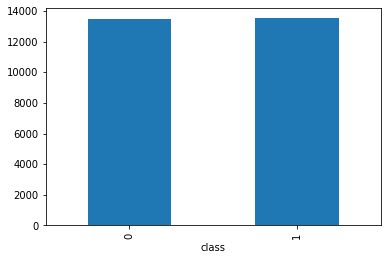

In [7]:
train.groupby('class')['class'].count().plot(kind="bar")

count    27000.000000
mean       396.756556
std        352.174353
min         16.000000
25%        171.000000
50%        295.500000
75%        504.000000
max       7014.000000
Name: preprocess_text, dtype: float64


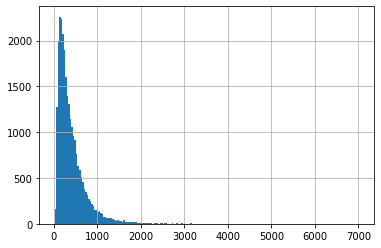

In [8]:
train['preprocess_text'].str.len().hist(bins=200)
print(train['preprocess_text'].str.len().describe())

In [9]:

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

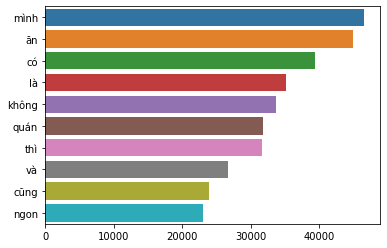

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
top_bi_bigrams=get_top_ngram(train['preprocess_text'],1)[:10]
x1,y1=map(list,zip(*top_bi_bigrams))
sns.barplot(x=y1,y=x1)

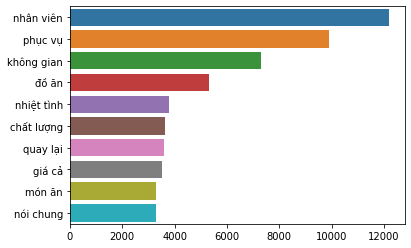

In [11]:
top_bi_bigrams=get_top_ngram(train['preprocess_text'],2)[:10]
x2,y2=map(list,zip(*top_bi_bigrams))
sns.barplot(x=y2,y=x2)

# Model

In [12]:
from fairseq.data import Dictionary
import sentencepiece as spm
from os.path import join as pjoin
from transformers import PreTrainedTokenizer
import sentencepiece as spm


In [13]:
!apt-get install git-lfs
!git lfs clone https://huggingface.co/vinai/phobert-base

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
fatal: destination path 'phobert-base' already exists and is not an empty directory.
Error(s) during clone:
git clone failed: exit status 128


In [14]:
from transformers import RobertaConfig, RobertaForSequenceClassification, AutoTokenizer
import torch

pretrained_path = '/content/phobert-base/'
!ls $pretrained_path
# load tokenizer
roberta = RobertaForSequenceClassification.from_pretrained(pretrained_path)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")


bpe.codes    flax_model.msgpack  README.md    vocab.txt
config.json  pytorch_model.bin	 tf_model.h5


Some weights of the model checkpoint at /content/phobert-base/ were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/phobert-base/ and are newly initial

In [15]:
# try to convert some text into numbers
inputs = ["Tôi ghét nó", "Tôi thích nó", "Tôi quý nó"]
inputs = tokenizer(inputs, return_tensors='pt')
print(inputs)
outputs = roberta(**inputs, labels=torch.tensor([0, 1, 1]))
print(outputs)

{'input_ids': tensor([[   0,  218, 5853,  231,    2],
        [   0,  218,  543,  231,    2],
        [   0,  218,  882,  231,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}
SequenceClassifierOutput(loss=tensor(0.7394, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0810, -0.1489],
        [ 0.0898, -0.0490],
        [ 0.1264, -0.1982]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [16]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


class SentimentRoberta(pl.LightningModule):
    """
    SentimentRoberta class inherits from LightningModule
    This class is used to train a model using PyTorch Lightning
    It overrides the following methods:
        - forward : forward pass of the model
        - training_step : training step of the model
        - validation_step : validation step of the model
        - validation_epoch_end : end of the validation epoch
        - configure_optimizers : configure optimizers
    """
    def __init__(self, lr_roberta, lr_classifier):
        """
        Initialize the model with the following parameters:
            - lr_roberta : learning rate of the roberta model
            - lr_classifier : learning rate of the classifier model
        """
        super().__init__()
        self.roberta = RobertaForSequenceClassification.from_pretrained(pretrained_path)
        self.tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

        self.lr_roberta = lr_roberta
        self.lr_classifer = lr_classifier

    def forward(self, texts, labels=None):
        """
        Forward pass of the model
        Args:
            - texts : input texts
            - labels : labels of the input texts
        """
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
        for key in inputs:
            inputs[key] = inputs[key].to(self.device)

        outputs = self.roberta(**inputs, labels=labels)
        return outputs

    def configure_optimizers(self):
        """
        Configure optimizers
        This method is used to configure the optimizers of the model by using the learning rate
        for specific parameter of the roberta model and the classifier model
        """
        roberta_params = self.roberta.roberta.named_parameters()
        classifier_params = self.roberta.classifier.named_parameters()

        grouped_params = [
            {"params": [p for n, p in roberta_params], "lr": self.lr_roberta},
            {"params": [p for n, p in classifier_params], "lr": self.lr_classifer}
        ]
        optimizer = torch.optim.AdamW(
            grouped_params
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'f1/val',
            }
        }

    def training_step(self, batch, batch_idx):
        """
        Training step of the model
        Args:
            - batch : batch of the data
            - batch_idx : index of the batch
        """
        texts, labels = batch
        outputs = self(texts, labels=labels)

        if len(outputs.values()) == 3:
            loss, logits, _ = outputs.values()
        else:
            loss, logits = outputs.values()
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step of the model, used to compute the metrics
        Args:
            - batch : batch of the data
            - batch_idx : index of the batch
        """
        texts, labels = batch
        outputs = self(texts, labels=labels)

        if len(outputs.values()) == 3:
            loss, logits, _ = outputs.values()
        else:
            loss, logits = outputs.values()

        output_scores = torch.softmax(logits, dim=-1)
        return loss, output_scores, labels

    def validation_epoch_end(self, validation_step_outputs):
        """
        End of the validation epoch, this method will be called at the end of the validation epoch,
        it will compute the multiple metrics of classification problem
        Args:
            - validation_step_outputs : outputs of the validation step
        """

        val_preds = torch.tensor([], device=self.device)
        val_scores = torch.tensor([], device=self.device)
        val_labels = torch.tensor([], device=self.device)
        val_loss = 0
        total_item = 0

        for idx, item in enumerate(validation_step_outputs):
            loss, output_scores, labels = item

            predictions = torch.argmax(output_scores, dim=-1)
            val_preds = torch.cat((val_preds, predictions), dim=0)
            val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
            val_labels = torch.cat((val_labels, labels), dim=0)

            val_loss += loss
            total_item += 1

        # print("VAL PREDS", val_preds.shape)
        # print("VAL SCORES", val_scores.shape)
        # print("VAL LABELS", val_labels.shape)
        val_preds = val_preds.cpu().numpy()
        val_scores = val_scores.cpu().numpy()
        val_labels = val_labels.cpu().numpy()

        reports = classification_report(val_labels, val_preds, output_dict=True)
        print("VAL LABELS", val_labels)
        print("VAL SCORES", val_scores)
        try:
            auc = roc_auc_score(val_labels, val_scores)
        except Exception as e:
            print(e)
            print("Cannot calculate AUC. Default to 0")
            auc = 0
        accuracy = accuracy_score(val_labels, val_preds)

        print(classification_report(val_labels, val_preds))

        self.log("loss/val", val_loss)
        self.log("auc/val", auc)
        self.log("accuracy/val", accuracy)
        self.log("precision/val", reports["weighted avg"]["precision"])
        self.log("recall/val", reports["weighted avg"]["recall"])
        self.log("f1/val", reports["weighted avg"]["f1-score"])

In [ ]:

trainer = pl.Trainer(
    fast_dev_run=True,
)
model = SentimentRoberta(lr_roberta=1e-5, lr_classifier=3e-3)
dm = SentimentDataModule()

trainer.fit(model, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1580: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
Some weights of the model checkpoint at /content/phobert-base/ were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another t

27000 21600 5400


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:408: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

# Training

In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/colab/tb_logs2/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(model, dm)

TEST

In [ ]:
# show the result here
%reload_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/colab/tb_logs2/'

In [ ]:
# test the model with some sentence
inputs = ["Cái tai nghe này rẻ thế "]
outputs = model(inputs)
logits = outputs['logits']
score = torch.softmax(logits, dim=-1)
Labels = ["Positive", "Negative"]
print(score)
print(f"The sentence: '{inputs[0]}' has {Labels[torch.argmax(score, dim=-1).item()]} tone with confident score : {score[torch.argmax(score, dim=-1).item()]}" )
